In [1]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


## Import

In [2]:
import pandas
import numpy
from folding_group import FoldingGroupClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
import root_numpy
data_nan = pandas.DataFrame(root_numpy.root2array('datasets/data/csv/JPsiK/Tracks.root'))

In [5]:
data_nan.head()

,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,...,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut
0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,0.056365,...,1.058442,-211,0.911645,1,-1,0.114615,0.59521,0,0,0
1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,0.033095,...,3.121358,-211,0.796731,1,-1,0.051334,0.59521,0,0,0
2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,0.077636,...,10.585135,-211,0.946629,1,-1,1.856516,0.59521,0,0,0
3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,0.086603,...,7.485243,211,1.058989,1,1,0.577419,0.59521,0,0,0
4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,0.015694,...,5.617354,211,1.042135,1,1,1.314513,0.59521,0,0,0


In [6]:
event_id_column = 'event_id'
event_id = data_nan.run.apply(str) + '_' + data_nan.event.apply(str)
data_nan['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
data_nan[event_id_column] = event_id

In [7]:
get_events_statistics(data_nan)

{'Events': 1005757, 'tracks': 27156193}

In [8]:
get_N_B_events()

742867.7142562866

## Remove rows with NAN from data

In [9]:
data = data_nan.dropna()
len(data_nan), len(data), get_events_statistics(data)

(27156193, 27156190, {'Events': 1005757, 'tracks': 27156190})

## Add diff_pt and cos(diff_phi)

In [10]:
from utils import add_diff_pt
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data['cos_diff_phi'] = numpy.cos(data.diff_phi.values)

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

## Add max, sum among PIDs

In [11]:
from itertools import combinations
PIDs = {'k': data.PIDNNk.values,
        'e': data.PIDNNe.values,
        'mu': data.PIDNNm.values,
       }
for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
    data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
    data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [12]:
data.loc[:, 'label'] = (data.signB.values * data.signTrack.values > 0) * 1

In [13]:
', '.join(data.columns)

'run, event, Bmass, i, mult, partP, partPt, ptB, IPs, IP, IPerr, partlcs, EOverP, ghostProb, IPPU, nnkrec, PIDNNk, PIDNNpi, PIDNNp, PIDNNm, PIDNNe, diff_eta, diff_phi, phi, eta, proj, ID, veloch, signB, signTrack, Dist_phi, N_sig_sw, mu_cut, e_cut, K_cut, group_column, event_id, diff_pt, cos_diff_phi, max_PID_mu_k, sum_PID_mu_k, max_PID_mu_e, sum_PID_mu_e, max_PID_k_e, sum_PID_k_e, label'

## Apply ghost prob cut

In [14]:
initial_cut = '(ghostProb < 0.4)'
data = data.query(initial_cut)

In [15]:
get_events_statistics(data)

{'Events': 1005751, 'tracks': 25567912}

## Leave not muons, kaons, electrons, protons, pions

In [16]:
threshold_kaon = 0.
threshold_muon = 0.
threshold_electron = 0.
threshold_pion = 0.
threshold_proton = 0.
cut_pid = " ( (PIDNNk > {trk}) | (PIDNNm > {trm}) | (PIDNNe > {tre}) | (PIDNNpi > {trpi}) | (PIDNNp > {trp})) "
cut_pid = cut_pid.format(trk=threshold_kaon, trm=threshold_muon, tre=threshold_electron, trpi=threshold_pion, 
                         trp=threshold_proton)
    
data = data.query(cut_pid)

In [17]:
get_events_statistics(data)

{'Events': 1005751, 'tracks': 25531030}

## Tracks sum of charges asymmetry checks

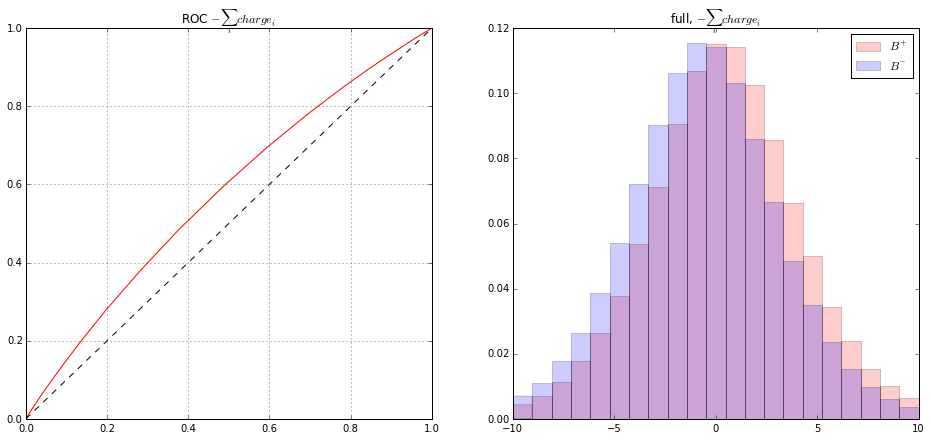

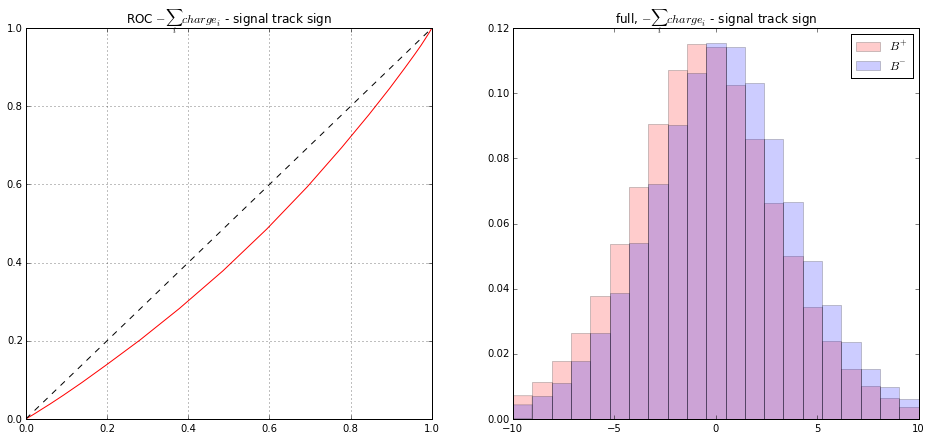

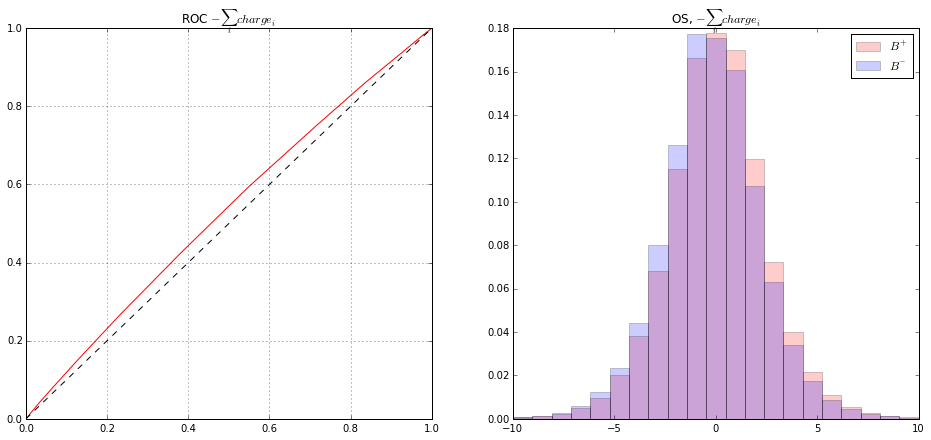

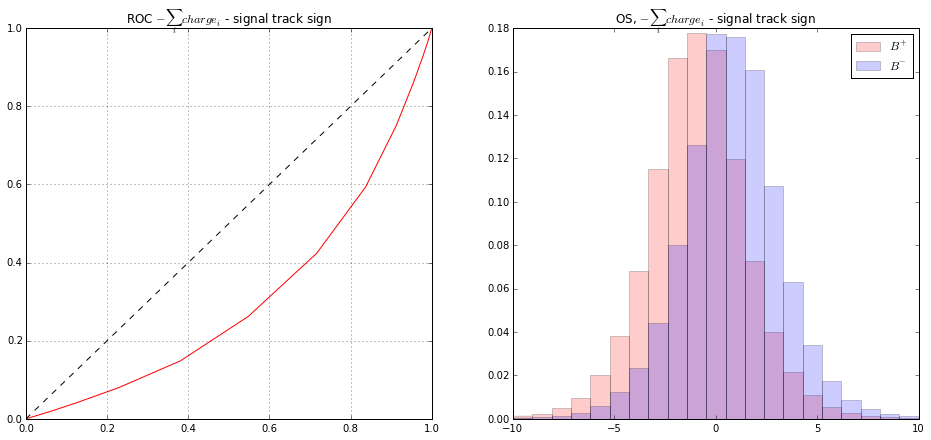

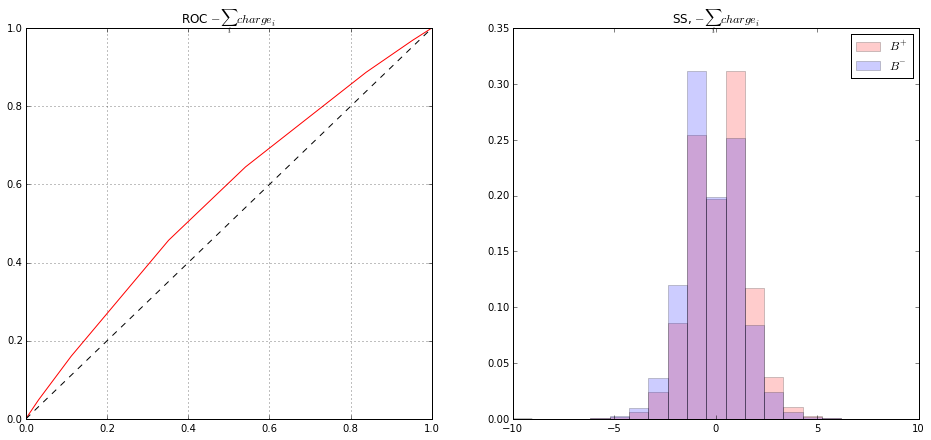

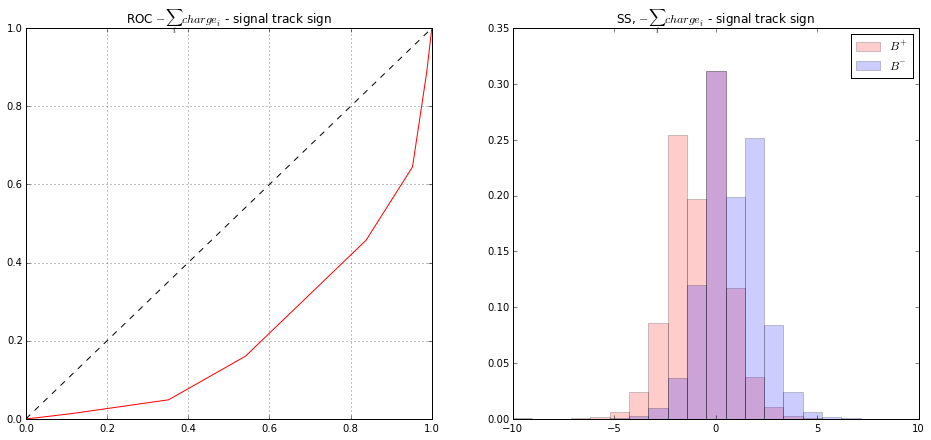

In [18]:
from utils import compute_sum_of_charges
means = [compute_sum_of_charges(data[mask], name, bins=bins,
                                event_id_column=event_id_column) for mask, name, bins in \
         zip([data.signB > -100, 
              (data.IPs > 3) & ((abs(data.diff_eta) > 0.6) | (abs(data.diff_phi) > 0.825)), 
              (abs(data.diff_eta) < 0.6) & (abs(data.diff_phi) < 0.825) & (data.IPs < 3)], 
             ['full', 'OS', 'SS'], [21, 21, 21])]

## Calculating tagging efficiency ($\epsilon_{tag}$)

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight (sWeight for signal)

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{\epsilon_{tag}(1-\epsilon_{tag}) \sum_{\text{all events}}sw_i^2}} {N (\text{all events})}$$

All events are not availables (some selections are applyed before), that is why we used 
$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})},$$
which is similar to the previous definition

In [19]:
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = sqrt(N_B_passed) / get_N_B_events()
tagging_efficiency, tagging_efficiency_delta

(0.9998594747982512, 0.0011601489231241832)

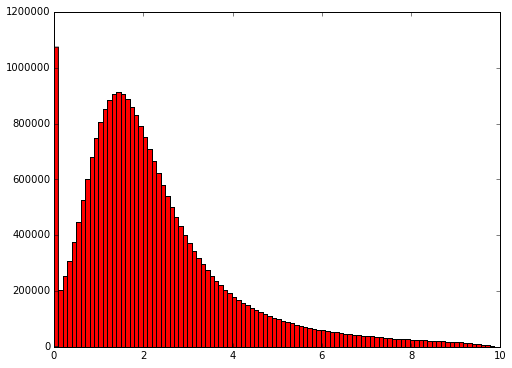

In [20]:
hist(data.diff_pt.values, bins=100)
pass

## Choose most probable B-events

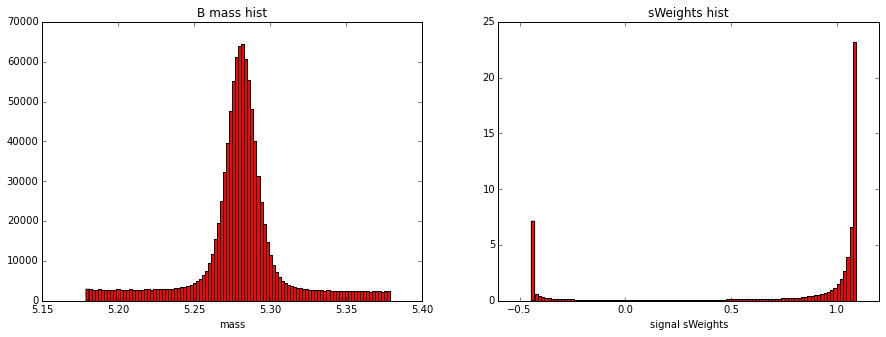

In [21]:
_, take_indices = numpy.unique(data[event_id_column], return_index=True)

figure(figsize=[15, 5])

subplot(1, 2, 1)
hist(data.Bmass.values[take_indices], bins=100)
title('B mass hist')
xlabel('mass')

subplot(1, 2, 2)
hist(data.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist')
xlabel('signal sWeights')
plt.savefig('img/Bmass_less_PID.png' , format='png')

### Define B-like events for training 

Events with low sWeight still will be used only to test quality.

In [22]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 614418, 'tracks': 15266383}

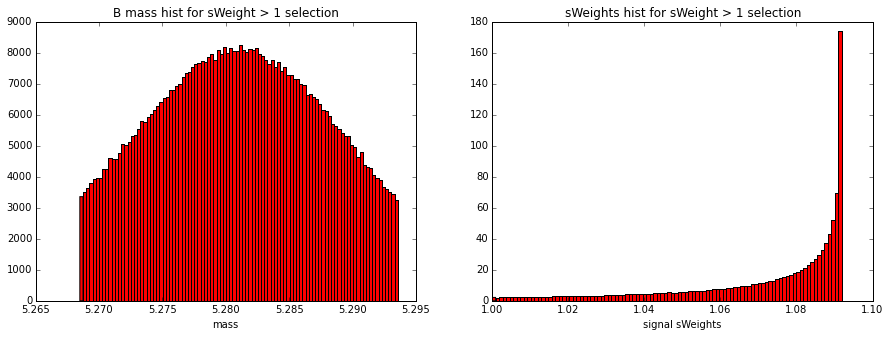

In [23]:
_, take_indices = numpy.unique(data_sw_passed[event_id_column], return_index=True)

figure(figsize=[15, 5])
subplot(1, 2, 1)
hist(data_sw_passed.Bmass.values[take_indices], bins=100)
title('B mass hist for sWeight > 1 selection')
xlabel('mass')

subplot(1, 2, 2)
hist(data_sw_passed.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist for sWeight > 1 selection')
xlabel('signal sWeights')
plt.savefig('img/Bmass_selected_less_PID.png' , format='png')

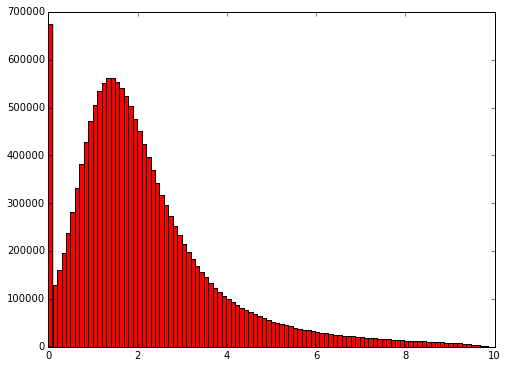

In [24]:
hist(data_sw_passed.diff_pt.values, bins=100)
pass

# Main idea: 
## find tracks, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [25]:
features = list(set(data.columns) - {'index', 'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label', 'thetaMin', 'Dist_phi', event_id_column, 
                                     'mu_cut', 'e_cut', 'K_cut', 'ID', 'diff_phi', 'group_column'})
features

['cos_diff_phi',
 'diff_pt',
 'partPt',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'ptB',
 'sum_PID_mu_k',
 'proj',
 'PIDNNe',
 'sum_PID_k_e',
 'PIDNNk',
 'sum_PID_mu_e',
 'PIDNNm',
 'phi',
 'IP',
 'IPerr',
 'IPs',
 'veloch',
 'max_PID_k_e',
 'ghostProb',
 'IPPU',
 'eta',
 'max_PID_mu_e',
 'max_PID_mu_k',
 'partlcs']

## PID pairs scatters

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


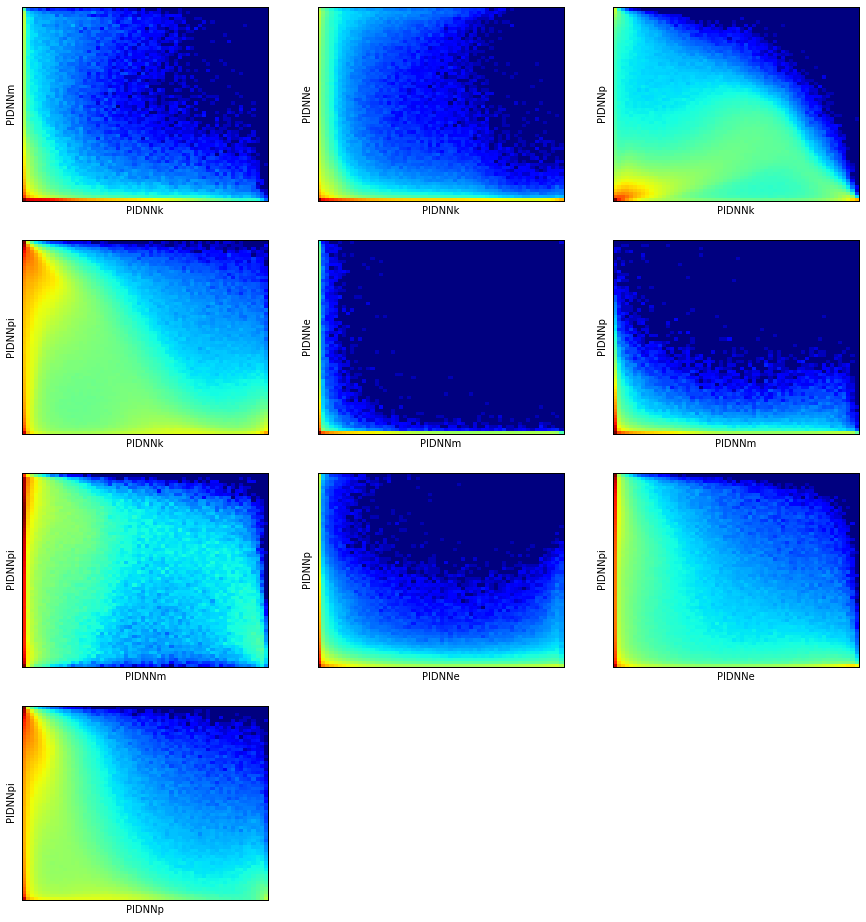

In [26]:
figure(figsize=[15, 16])
bins = 60
step = 3
for i, (feature1, feature2) in enumerate(combinations(['PIDNNk', 'PIDNNm', 'PIDNNe', 'PIDNNp', 'PIDNNpi'], 2)):
    subplot(4, 3, i + 1)
    Z, (x, y) = numpy.histogramdd(data_sw_passed[[feature1, feature2]].values, bins=bins, range=([0, 1], [0, 1]))
    pcolor(numpy.log(Z).T, vmin=0)
    xlabel(feature1)
    ylabel(feature2)
    xticks(numpy.arange(bins, step), x[::step]), yticks(numpy.arange(bins, step), y[::step])
plt.savefig('img/PID_selected_less_PID.png' , format='png')

## pt

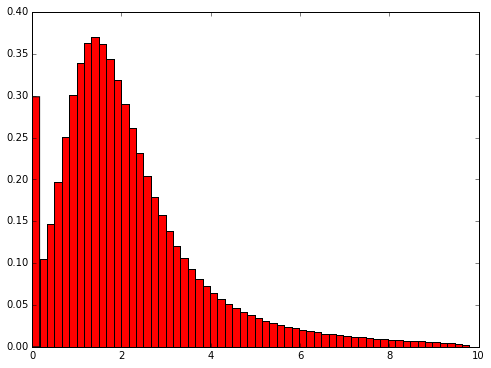

In [27]:
hist(data_sw_passed.diff_pt.values, bins=60, normed=True)
pass

## count of tracks

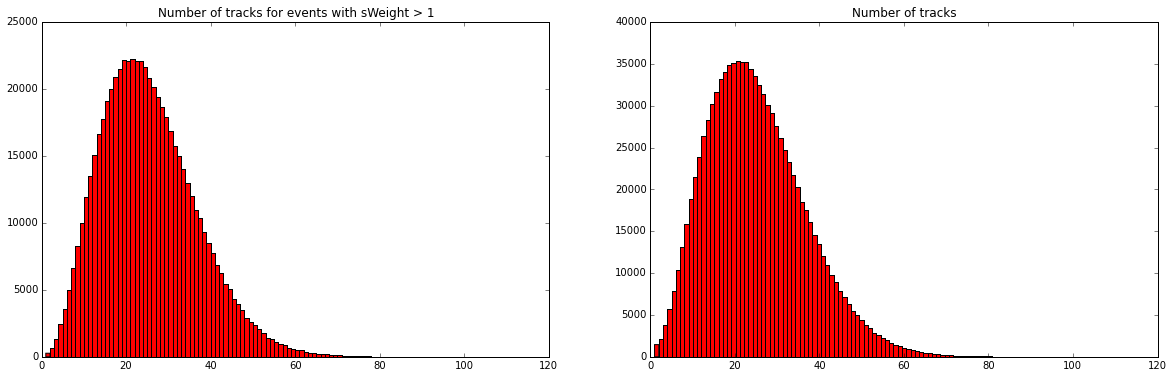

In [28]:
figure(figsize=(20, 6))

subplot(1, 2, 1)
_, n_tracks = numpy.unique(data_sw_passed[event_id_column], return_counts=True)
hist(n_tracks, bins=100)    
title('Number of tracks for events with sWeight > 1')

subplot(1, 2, 2)
_, n_tracks_all = numpy.unique(data[event_id_column], return_counts=True)
hist(n_tracks_all, bins=106)    
title('Number of tracks')

plt.savefig('img/tracks_number_less_PID.png' , format='png')

## PIDs histograms

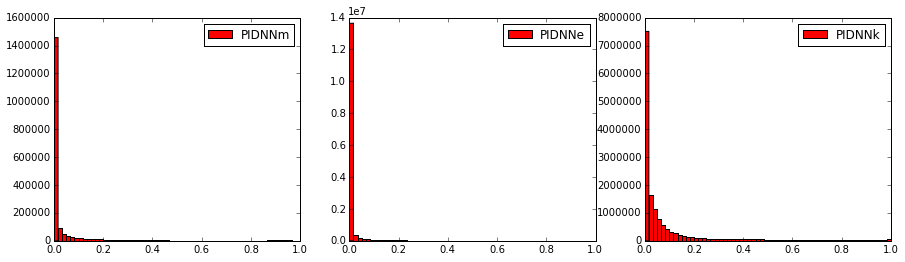

In [29]:
figure(figsize=[15, 4])
for i, column in enumerate(['PIDNNm', 'PIDNNe', 'PIDNNk']):
    subplot(1, 3, i + 1)
    hist(data_sw_passed[column].values, bins=60, range=(0, 1), label=column)
    legend()

----

## Train to distinguish same sign vs opposite sign

In [30]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from hep_ml.losses import LogLossFunction

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [31]:
data_sw_passed_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values)

### DT

In [32]:
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=3000, depth=6,
                                  max_features=15, n_threads=14, loss=LogLossFunction(regularization=100))
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 59min 16s, sys: 17min 38s, total: 1h 16min 54s
Wall time: 24min 11s


In [33]:
import cPickle
with open('models/dt_full_group.pkl', 'w') as f:
    cPickle.dump(tt_folding, f)

In [34]:
# import cPickle
# with open('models/dt_full_group.pkl', 'r') as f:
#     tt_folding = cPickle.load(f)

In [35]:
comparison_report = tt_folding.test_on_lds(data_sw_passed_lds)
comparison_report.compute_metric(RocAuc())

KFold prediction using folds column


OrderedDict([('clf', 0.51339709374699827)])

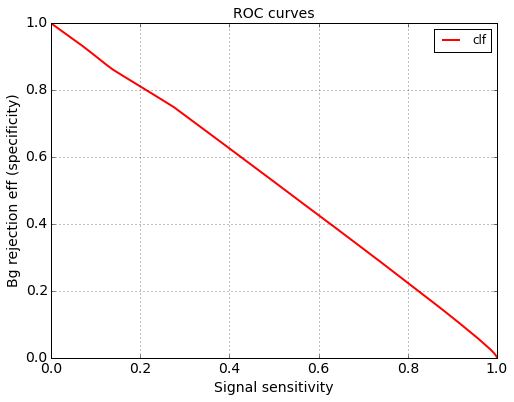

In [36]:
comparison_report.roc()

In [37]:
lc = comparison_report.learning_curve(RocAuc(), steps=1)

KFold prediction using folds column


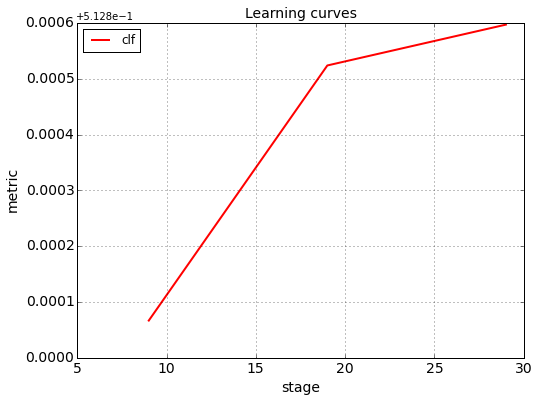

In [38]:
lc

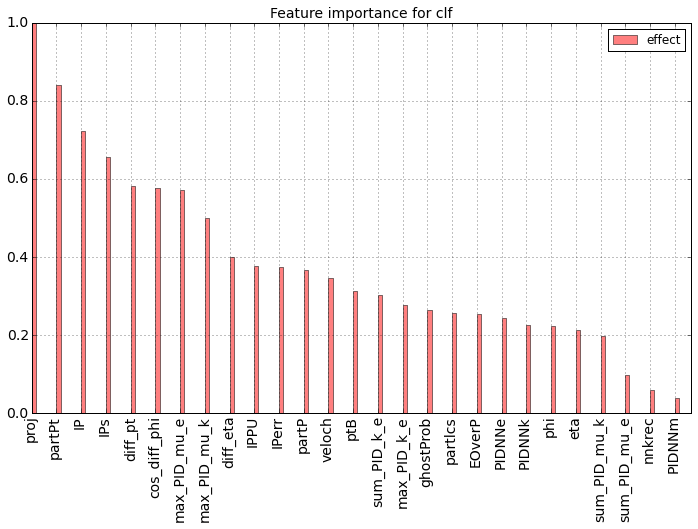

In [39]:
comparison_report.feature_importance()

# Calibration

In [40]:
from utils import get_result_with_bootstrap_for_given_part

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


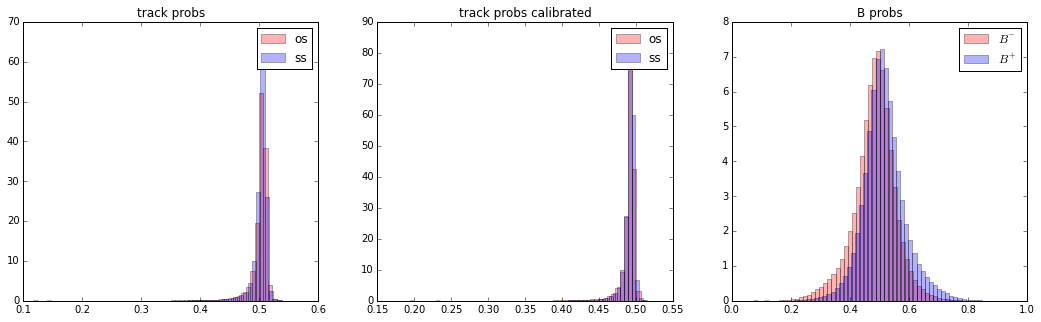

AUC for tagged: 0.645996527538 AUC with untag: 0.645984044477
mean AUC after calibration: 0.645837546674 4.96562532438e-07


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,99.985947,0.116015,0.064034,0.000548,6.402483,0.055303,64.598404,0


In [42]:
result = get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                 [data_sw_passed, data_sw_not_passed], 'tt-log', get_N_B_events(),
                                                 logistic=True, n_calibrations=30)
result

In [75]:
import utils
reload(utils)

<module 'utils' from 'utils.pyc'>

In [76]:
from utils import get_result_with_bootstrap_for_given_part

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


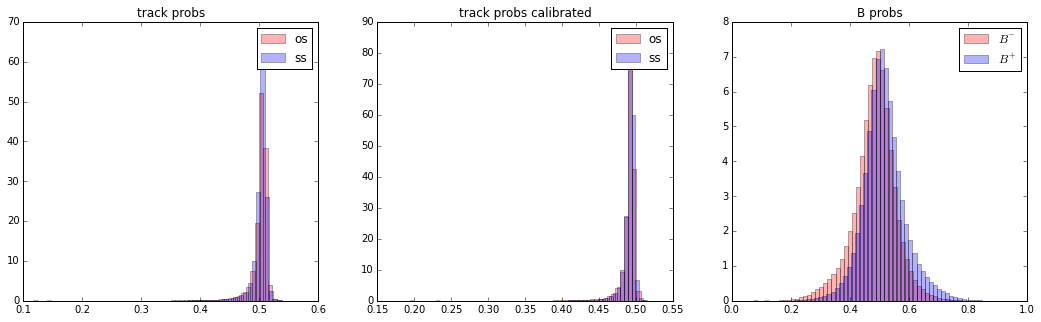

AUC for tagged: 0.645996527538 AUC with untag: 0.645984044477


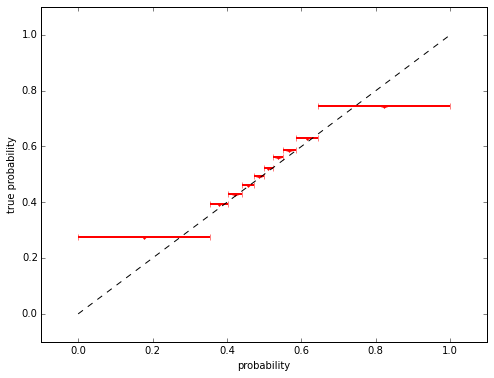

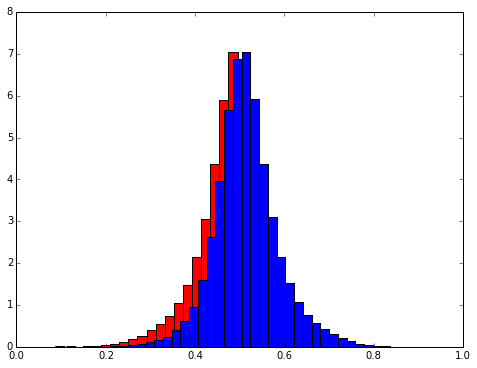

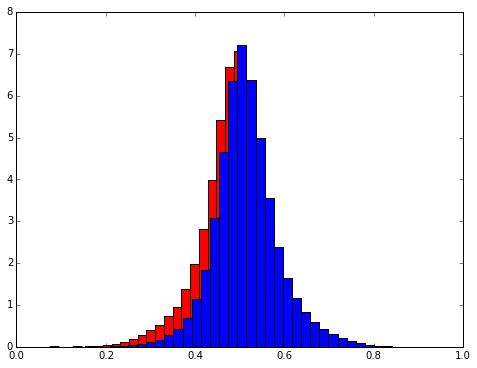

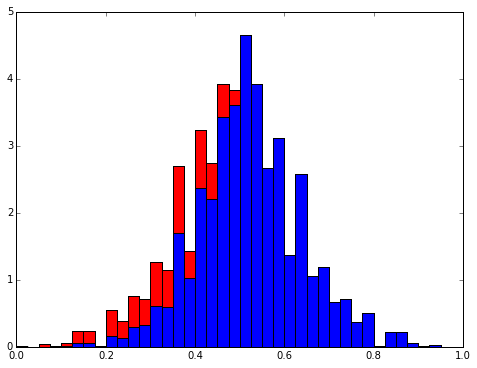

250805.477079 250375.542524 0.0216527608643 0.0587237431299 mean AUC after calibration: 0.646299951057 0.0


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,99.985947,0.116015,0.06298,0,6.297123,0.007307,64.598404,0


In [77]:
result = get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                 [data_sw_passed, data_sw_not_passed], 'tt-log', get_N_B_events(),
                                                 logistic=True, n_calibrations=1)
result

In [45]:
result.to_csv('img/tracks.csv', index=False, header=True)

--------------------------

## Implementing best tracking

In [46]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


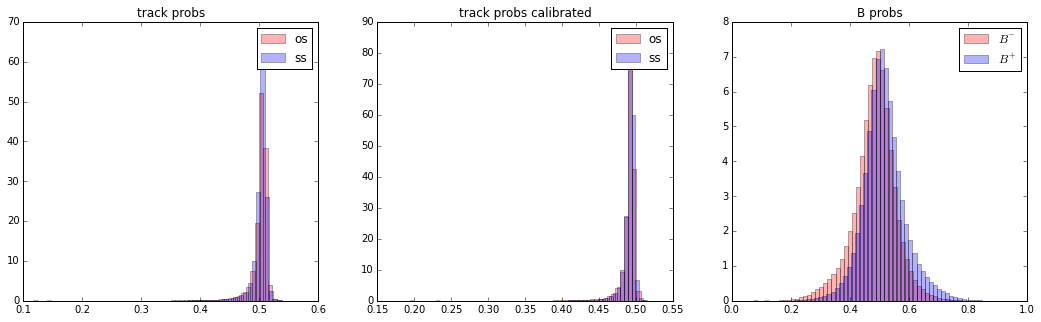

AUC for tagged: 0.645996527538 AUC with untag: 0.645984044477


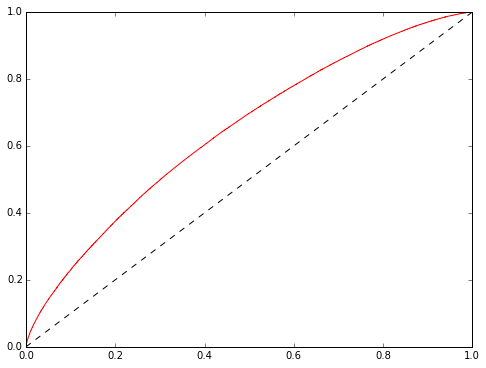

In [47]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data_sw_passed, data_sw_not_passed], 
                                               get_N_B_events(), logistic=True)

In [48]:
Bdata_prepared.to_csv('models/Bdata_tracks.csv', header=True, index=False)

## MC trained algorithm testing

In [ ]:
from utils import estimate_algorithm

In [91]:
import cPickle
with open('models/dt_MC.pkl', 'r') as f:
    tt_folding_MC = cPickle.load(f)
with open('models/calibrator_tracks_MC.pkl', 'r') as f:
    calibrator_tracks_MC = cPickle.load(f)
with open('models/calibrator_B_MC.pkl', 'r') as f:
    calibrator_B_MC = cPickle.load(f)

In [83]:
p_MC = tt_folding_MC.predict_proba(data)[:, 1]
roc_auc_score(data.label, p_MC, sample_weight=data.N_sig_sw.values.astype(float64))

KFold prediction using random classifier (length of data passed not equal to length of train)


0.5136458713571046

KFold prediction using random classifier (length of data passed not equal to length of train)
0.513645871357 0.513645871357
without calibration 0.639956534153 0.63994452104
with calibration 0.639956533883 0.639944519282


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,SS,99.985947,0.116015,0.075613,0,7.560273,0.008772,63.994452,0


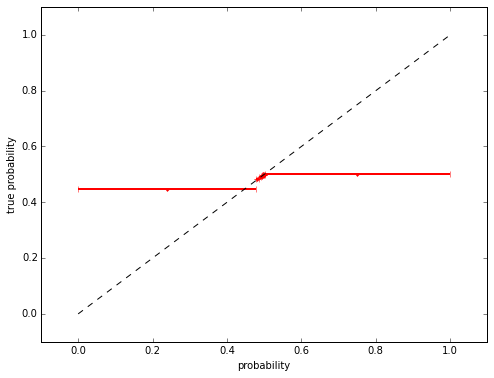

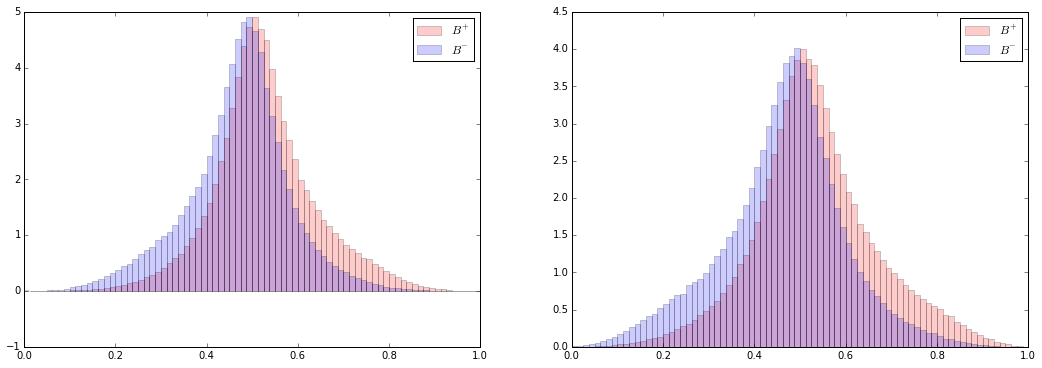

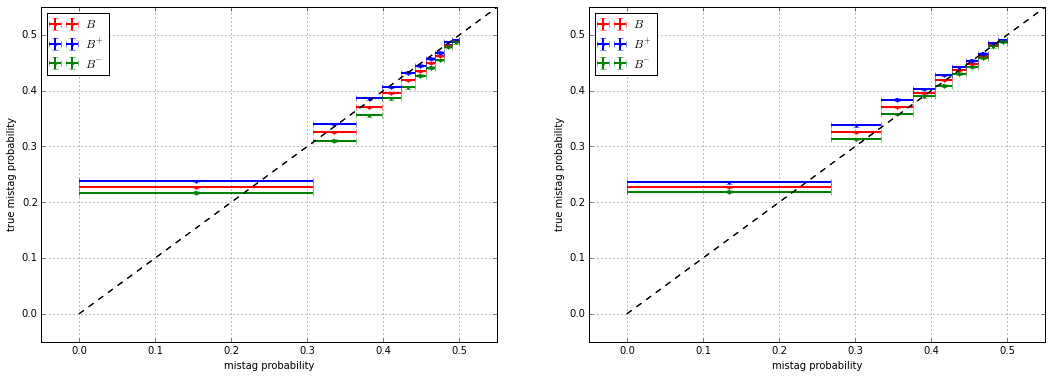

In [93]:
estimate_algorithm(tt_folding_MC, calibrator_tracks_MC, calibrator_B_MC, data, get_N_B_events())

KFold prediction using random classifier (length of data passed not equal to length of train)
0.513645871357 0.513644576064
without calibration 0.641425721223 0.641413560639
with calibration 0.6414235608 0.641411411784


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,inclusive,99.985947,0.116015,0.064091,0,6.408214,0.007436,64.141141,0


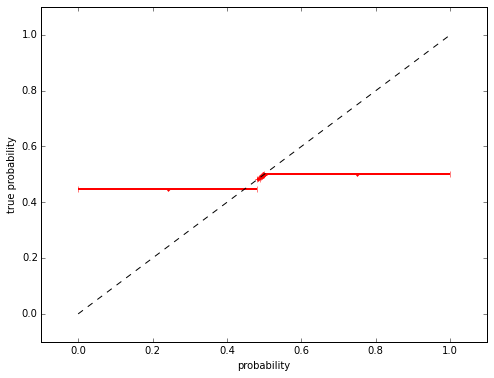

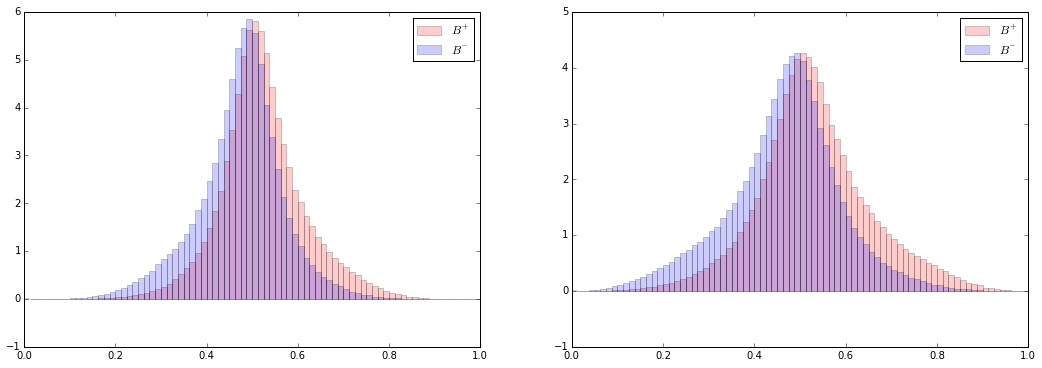

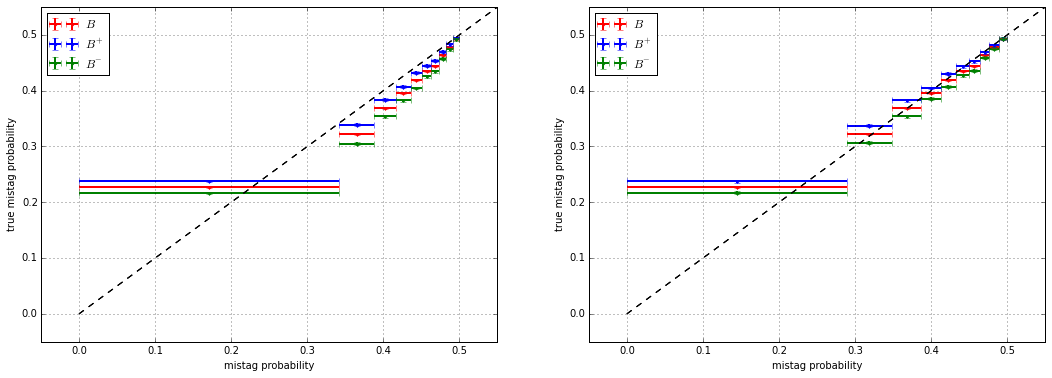

In [97]:
estimate_algorithm(tt_folding_MC, calibrator_tracks_MC, calibrator_B_MC, data, get_N_B_events(), calib_part_itself=True,
                   calib_itself=True)